## Load necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time, copy, warnings


import torch
from torch import nn
import torch.nn.functional as F


# setting random seeds for reproducibility of results
torch.manual_seed(0)
np.random.seed(0)


## functions to generate a QUBO problem instance, to compute all the energies, and to find global minimum through an exhaustive search 

$ $

A $n$-variable quadratic unconstrained binary optimization (QUBO) problem is equivalent to find a minimum energy eigenstate 
$E_\text{min} = \min_j \{E_j\}$, $E_j = \langle j |H| j\rangle 
= \sum_{\mu,\nu=1}^n \mathsf{Q}_{\mu\nu} j_\mu j_\nu$, 
of the associated $n$-qubit Hamiltonian 
$H = \sum_{\mu,\nu=1}^n \mathsf{Q}_{\mu\nu} P_\mu P_\nu$,
where $\mathsf{Q}$ is a $n\times n$ real matrix that defines the problem, and the projector $P_\mu$ acts on the $\mu$th qubit as $P_\mu|j_\mu \rangle = j_\mu|j_\mu \rangle\,, j_\mu\in\{0,1\}, |j\rangle \equiv \otimes_\mu |j_\mu\rangle, j=0,\cdots,d-1$, and $d=2^n$.
You can sample $\mathsf{Q}$ either from the discrete uniform distribution on $\{-10,\cdots,10\}$ or from the standard normal distribution.

$ $

In [2]:
def energy(j, Q):                                                # one-to-one correspondence: integer j <--> j_bin
    j_bin = np.array([int(jmu) for jmu in np.binary_repr(j, n)]) # j_bin has n components, each one is 0 or 1
    E = np.linalg.multi_dot([j_bin, Q, j_bin])                   # E = energy for a given j
    return E
    

def energies(n):                                # n = number of qubits
    d = 2**n                                    # d = dimension of the n-qubit Hilbert space
                                                # generating upper triangular real Q matrix
    #Q = np.random.randint(-10, 11, (n, n))     # from the discrete uniform distribution on {-10,...,10}
    Q = np.random.randn(n,n)                    # from the standard normal distribution
    Q = np.triu(Q)

    engs = []                                   # collection of all possible d energies for different j
    j_min, E_min = None, np.inf
    for j in range(d):                                                                                
        E = energy(j, Q)              
        engs.append(E)
        if E < E_min:
            E_min = E      # global minimum through an exhaustive search 
            j_min = j      # global minimum solution
    
    return np.array(engs), E_min, j_min             


## Quantum Machine Learning (QML) model : Interferometric Neural Network (INN)


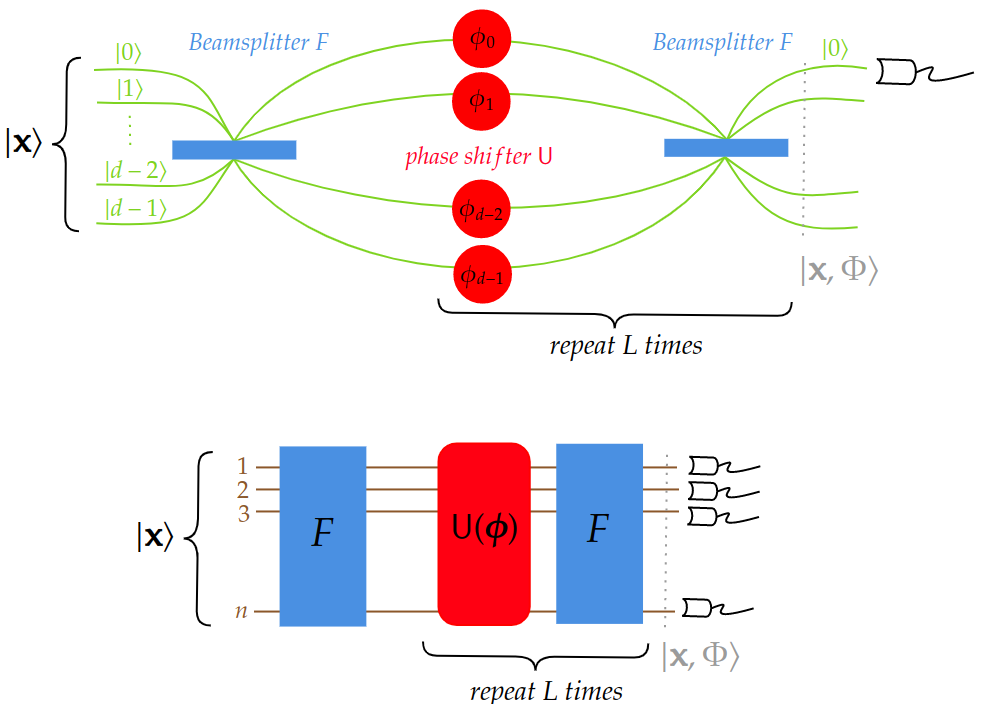


Beamsplitter (the discrete Fourier transformation)
$F = \frac{1}{\sqrt{d}}\sum_{k=0}^{d-1} \sum_{j=0}^{d-1} \omega^{\,kj}\,|k \rangle\langle j|$, where ${\omega=\text{e}^{\texttt{i}\frac{2\pi}{d}}}$ is a $d$th root of unity.

phase shifter
$U(\boldsymbol{\phi}) = \sum_{j=0}^{d-1}  \text{e}^{\texttt{i}\phi_j}|j \rangle\langle j|$

Here the input state is fixed:
$F|\textbf{x}\rangle = F|0 \rangle = \frac{1}{\sqrt{d}}\sum_{j=0}^{d-1}|j \rangle = |+ \rangle$

In [3]:
class Interferometer(nn.Module):
    def __init__(self, d):
        super(Interferometer, self).__init__()
        
        
        torch.manual_seed(1)                              # setting a specific seed for reproducibility of results    
        phases = torch.empty((1, d), dtype=torch.float)   # Initialize learnable phases
        nn.init.xavier_uniform_(phases)     
        self.phases = nn.Parameter(phases) 
        
        
    def forward(self, x):                          
        x = x * torch.exp(1j * self.phases)        # Perform the phase shifter
        x = torch.fft.fft(x, norm='ortho')         # Perform 1D Fast Fourier Transform (beamsplitter)
        return x                                  

    
#------------------------------------------------------------------------------------------------

'''Here, the INN is a sequence L Interferometers'''

class INN(nn.Module):                                      
    def __init__(self, d, L):                 
        super(INN, self).__init__()
        
        self.d = d
        self.L = L                                             # number of quantum layers
        
        self.phase_filters_layers = nn.ModuleList([Interferometer(d) for _ in range(L)])
        
        
    def forward(self):   # initialize x to |+> ket that is an equal superposition of all computational basis-kets
        x = torch.ones(self.d)/torch.sqrt(torch.tensor(self.d))   # |+> = F|0>
        
        for phase_filters in self.phase_filters_layers:
            x = phase_filters(x)
        
        x = x*(x.conj())                 # measurement in the computational basis and getting the probabilities 
        x = torch.real(x).squeeze()      # dropping the imaginary components 0j
    
        return x 
    

#================================================================================================

def training(Es):
    model.train()
    optimizer.zero_grad()               # Clear gradients
    out = model()                       # Perform a single forward pass, out = 𝐩(Φ) = (𝑝0,⋯,𝑝dim-1) 
    #print(torch.sum(out))              # Checking whether probabilities add up to 1 or not
    loss = torch.dot(out, torch.tensor(Es, dtype=torch.float)) # 𝐿𝑜𝑠𝑠(Φ)=⟨Φ|𝐻|Φ⟩ = ∑𝑝j𝐸j is the energy expectation
    loss.backward()                     # Derive gradients
    optimizer.step()                    # Update parameters based on gradients
    return loss

#================================================================================================ 

def plot(engs, E_min, E_sol):
    #plt.stem(engs)
    plt.scatter(np.arange(d), engs, s=10, c='blue')
    plt.axhline(y = 0, color = 'black', linestyle = '-')
    plt.axhline(y = E_min, color = 'red', linestyle = '-')
    plt.ylabel(r'$E_j = \langle j|H|j\rangle$')
    plt.axhline(y = E_sol, color = 'green', linestyle = '--', linewidth=3, alpha=0.7)
    plt.xlabel('j')
    plt.show()
    

## Optimality Gaps in different QUBO problem instances

In [4]:
%%time

n = 17
L = 2
epochs = 201
num_instance = 1000

d = 2**n


#================================================================================================
Opt_Gap = []

for i in range(num_instance):
    
    # generating a QUBO problem instance, computing all the energies, global minimum through an exhaustive search
    engs, E_min, j_min  = energies(n=n)   
 
    #-----------------------------------------------------------------------------------------
    
    model = INN(d=d,L=L)                                                         # initalizing the QML model
    optimizer = torch.optim.Adam(model.parameters(), lr=0.05, betas=(0.5, 0.9))  
    for epoch in range(epochs):                                                  # model training ...
        loss = training(engs)
    
    #-----------------------------------------------------------------------------------------
    
    out_prob = model().detach()            # after the training, get the output porbabilities

    j_sol = torch.argmax(out_prob)         # j corresponding to the maximum probability will be our solution
    E_sol = engs[j_sol]                    # obtained minimum through INN
    
    
    # optimality gap = |(obtained min - global min) / global min| 100 %
    opt_gap = abs((E_sol - E_min)/(E_min+1e-10)) * 100 
    
    Opt_Gap.append(opt_gap)
    
    if i % 100 == 0:
        #plot(engs, E_min, E_sol)
        print(f'instance: {i:03d}    optimality gap: {opt_gap:.2f} %     (E_sol, E_min) = {E_sol, E_min}')

    
print()

instance: 000    optimality gap: 0.00 %     (E_sol, E_min) = (-20.130876210948163, -20.130876210948163)
instance: 100    optimality gap: 0.00 %     (E_sol, E_min) = (-20.96347590127728, -20.96347590127728)
instance: 200    optimality gap: 0.00 %     (E_sol, E_min) = (-21.119191724452225, -21.119191724452225)
instance: 300    optimality gap: 0.00 %     (E_sol, E_min) = (-6.778500909092535, -6.778500909092535)
instance: 400    optimality gap: 0.00 %     (E_sol, E_min) = (-20.937425919336533, -20.937425919336533)
instance: 500    optimality gap: 0.00 %     (E_sol, E_min) = (-20.29662929791426, -20.29662929791426)
instance: 600    optimality gap: 0.00 %     (E_sol, E_min) = (-27.12712052638919, -27.12712052638919)
instance: 700    optimality gap: 0.00 %     (E_sol, E_min) = (-19.693225516594243, -19.693225516594243)
instance: 800    optimality gap: 0.00 %     (E_sol, E_min) = (-24.943461162835746, -24.943461162835746)
instance: 900    optimality gap: 0.00 %     (E_sol, E_min) = (-29.003659

## Save optimality gaps for the problem instances

In [5]:
#np.save('opt_gap_uniform.npy', Opt_Gap)  # Q is sampled from the discrete uniform distribution on {-10,...,10}
#np.save('opt_gap_normal.npy', Opt_Gap)   # Q is sampled from the standard normal distribution



Opt_Gap_uniform = np.load('opt_gap_uniform.npy')
Opt_Gap_normal = np.load('opt_gap_normal.npy')


## Plot optimality gaps for the problem instances

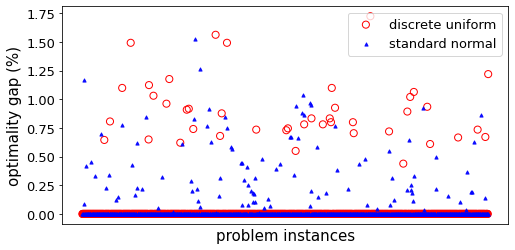

Q is sampled from the discrete uniform distribution on {-10,...,10}
[min, mean, max] optimality gap = [0.   0.04 1.72] %
Where optimality gap <= 1e-10, the number of instances is 958

Q is sampled from the standard normal distribution
[min, mean, max] optimality gap = [0.   0.04 1.52] %
Where optimality gap <= 1e-10, the number of instances is 894


In [6]:

plt.figure(figsize=(8, 4))
plt.scatter(np.arange(len(Opt_Gap_uniform)), Opt_Gap_uniform, s=50, marker='o', facecolors='none', edgecolors='r',
            label='discrete uniform')
plt.scatter(np.arange(len(Opt_Gap_normal)), Opt_Gap_normal, s=10, c='b', marker='^', alpha=0.9,
           label='standard normal')
plt.ylabel(r'optimality gap (%)', fontsize=15)
plt.xlabel('problem instances', fontsize=15)
plt.yticks(fontsize=13)
plt.xticks([])
plt.legend(fontsize=13)
plt.show()


print('Q is sampled from the discrete uniform distribution on {-10,...,10}')
min_mean_max_opt_gap_uniform = np.round([np.min(Opt_Gap_uniform), np.mean(Opt_Gap_uniform), 
                                         np.max(Opt_Gap_uniform)],2)
print(f'[min, mean, max] optimality gap = {min_mean_max_opt_gap_uniform} %')
print(f'Where optimality gap <= 1e-10, the number of instances is {len(np.where(np.array(Opt_Gap_uniform)<=1e-10)[0])}\n')




print('Q is sampled from the standard normal distribution')
min_mean_max_opt_gap_normal = np.round([np.min(Opt_Gap_normal), np.mean(Opt_Gap_normal), 
                                        np.max(Opt_Gap_normal)],2)
print(f'[min, mean, max] optimality gap = {min_mean_max_opt_gap_normal} %')
print(f'Where optimality gap <= 1e-10, the number of instances is {len(np.where(np.array(Opt_Gap_normal)<=1e-10)[0])}')

# $ $




$ $